##Text Generation using RNN LSTM (Pytorch)
###Lyrics generatator  
🤖 LSTM, GRU에 대해 한국어로 더 잘 알고 싶다면  
https://velog.io/@hipjaengyi_cat18/RNNRecurrent-Neural-Network과-LSTM-GPU를-이해해보자-내가보려고정리한AI  
🤖 참고한 코드  
https://github.com/trekhleb/machine-learning-experiments/tree/0cfc7cac2daaff3e37b33bbf1284d3f19a5d78a1/experiments/text_generation_shakespeare_rnn   
https://www.kaggle.com/code/super13579/let-s-auto-write-the-deep-purple-lysics-pytorch/notebook#Let's-use-the-Deep-Purple-lysics-to-train-a-LSTM-simulated-Deep-Purple-write-lyrics-automatically-(Rock!!)   
& special thanks to DS 22기 조성원  
🤖 데이터셋   
from kaggle  
🤖 LSTM 논문  
https://www.bioinf.jku.at/publications/older/2604.pdf  


##I. INTRODUCTION  
Implementing a Recurrent Neural Network (RNN), specifically Long-Short Term Memory (LSTM), to create a lyrics generator.

## Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

## Download the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# 드라이브에 있는 CSV 파일 읽기 예시 (lyrics.csv가 있는 파일 경로를 적어주세요)
file_path = '/content/drive/MyDrive/Colab Notebooks/와이빅타/lyrics/lyrics.csv'
df = pd.read_csv(file_path)

# data frame 확인
df.head()

,Unnamed: 0,artist,seq,song,label
0,0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,0.626
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,0.630
2,2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.240
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,0.536
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.371


In [4]:
#데이터 중 일부만 가져오기 - 가져올 데이터 자유롭게 선택해주세요
random_sample = df.sample(n=3000, random_state=123)

In [5]:
#가져온 데이터 확인
print(random_sample.head())

        Unnamed: 0        artist  \
4509          4509  The Business   
91329        91329        Justin   
68579        68579   Jack Jezzro   
51455        51455         Apple   
145469      145469  Steve Taylor   

                                                      seq               song  \
4509    You got no money and your feeling down\nCan't ...  Steal This Record   
91329   I can hear her heartbeat from a thousand miles...         Crazy Love   
68579   Listen to my tale of woe, \r\nIt's terribly sa...       Lady Be Good   
51455   If you see me and I'm coming\r\nFrom the other...      The Otherside   
145469  Sin For A Season\r\n\r\nThere's a sweaty hand ...   Sin for a Season   

        label  
4509    0.571  
91329   0.028  
68579   0.524  
51455   0.638  
145469  0.829  


##Analyze the dataset

In [6]:
#데이터프레임에서 'seq' 열(가사부분)을 선택하고, 각 행의 'seq' 값을 소문자로 변환
random_text = random_sample['seq'].str.cat(sep='\n').lower()
print(random_text[:100])
print('corpus length:', len(random_text))

you got no money and your feeling down
can't find it when you want it around
you see that record and
corpus length: 3416689


In [7]:
# Take a look at the first 286 characters in text.
print(random_text[:286])

you got no money and your feeling down
can't find it when you want it around
you see that record and you want it so much
i'll think i'll take it and try my luck

i'm in tanng and i don't think they noticed
i'm out of the door and on my toes
i hear a scream but they won't catch me
i'm a


In [8]:
# The unique characters in the file 확인
vocab = sorted(set(random_text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

70 unique characters
vocab: ['\t', '\n', '\r', ' ', '!', '"', '#', '$', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x7f']


##Process the dataset

###Vectorize the text
Recurrent Neural Network (RNN)에 텍스트 데이터를 입력으로 제공하기 전에, 텍스트를 문자의 시퀀스에서 숫자의 시퀀스로 변환하는 과정을 거칩니다.

In [9]:
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\t':   0,
  '\n':   1,
  '\r':   2,
  ' ' :   3,
  '!' :   4,
  '"' :   5,
  '#' :   6,
  '$' :   7,
  '&' :   8,
  "'" :   9,
  '(' :  10,
  ')' :  11,
  '*' :  12,
  '+' :  13,
  ',' :  14,
  '-' :  15,
  '.' :  16,
  '/' :  17,
  '0' :  18,
  '1' :  19,
  ...
}


In [10]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

len(index2char)

['\t' '\n' '\r' ' ' '!' '"' '#' '$' '&' "'" '(' ')' '*' '+' ',' '-' '.'
 '/' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@'
 '[' ']' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n'
 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '{' '|' '}' '~' '\x7f']


70

In [11]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in random_text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(random_text[:32]), repr(text_as_int[:32])))

text_as_int length: 3416689
'you got no money and your feelin' --> array([63, 53, 59,  3, 45, 53, 58,  3, 52, 53,  3, 51, 53, 52, 43, 63,  3,
       39, 52, 42,  3, 63, 53, 59, 56,  3, 44, 43, 43, 50, 47, 52])


## Create training sequences

In [12]:
seq_length = 50
step = 1
sentences = []
next_chars = []

for i in range(0, len(random_text) - seq_length, step):
  sentences.append(random_text[i:i+seq_length])
  next_chars.append(random_text[i+seq_length]) #Next character

senteces = np.array(sentences)
next_chars= np.array(next_chars)


#Print Sentence Window and next charaters
print('Sentence Window')
print (sentences[:5])
print('Target charaters')
print (next_chars[:5])
print('Number of sequences:', len(sentences))

Sentence Window
["you got no money and your feeling down\ncan't find ", "ou got no money and your feeling down\ncan't find i", "u got no money and your feeling down\ncan't find it", " got no money and your feeling down\ncan't find it ", "got no money and your feeling down\ncan't find it w"]
Target charaters
['i' 't' ' ' 'w' 'h']
Number of sequences: 3416639


In [13]:
def getdata(sentences, next_chars):
    X = np.zeros((len(sentences),seq_length))
    y = np.zeros((len(sentences)))
    length = len(sentences)
    index = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = char2index[char]
        y[i] = char2index[next_chars[i]]
    return X, y

In [14]:
train_x,train_y = getdata(sentences, next_chars)
print('Shape of training_x:', train_x.shape)
print('Shape of training_y:', train_y.shape)

Shape of training_x: (3416639, 50)
Shape of training_y: (3416639,)


##Build the Model(Pytorch)
## 추과 과제 1 : 아래 빈 곳을 채워주세요!
- Embedding layer : transfer index to embedding vector
- Simple LSTM + dropout : Sequence data to hidden states , dropout for prevent overfitting
- Fully connection layer : linear tranfer to a n_vocab vector to be output layer.  
we don't need to do softmax here, we will do it when we calculate loss function

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Simple_LSTM(nn.Module):
    def __init__(self,n_vocab,hidden_dim, embedding_dim,dropout = 0.2):
        super(Simple_LSTM, self).__init__()
        ##################################################################
        # TODO: 주석, ________ 부분 지우고 답안 작성해주세요.
        #
        # Hint: 위에 embedding layer, simple LSTM + dropout, fully connected layer 설명 부분을 읽고 채워주시면 됩니다.
        #
        ##################################################################
        # 아래 주석 해제 후 정의해주세요.
        self.hidden_dim = hidden_dim
        self.embedding_dim= embedding_dim
        self.lstm = nn.LSTM(hidden_dim, embedding_dim, dropout = dropout,num_layers = 2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
        ##################################################################
        #                         END OF YOUR CODE                       #
        ##################################################################

    def forward(self, seq_in):
        # for LSTM, input should be (Sequnce_length,batchsize,hidden_layer), so we need to transpose the input
        embedded = self.embeddings(seq_in.t())
        lstm_out, _ = self.lstm(embedded)
        # Only need to keep the last character
        ht=lstm_out[-1]
        out = self.fc(ht)
        return out

## Create DataLoader of mini-batch training
Use GPU to training

In [16]:
X_train_tensor = torch.tensor(train_x, dtype=torch.long).cuda()
Y_train_tensor = torch.tensor(train_y, dtype=torch.long).cuda()

In [17]:
from torch.utils.data import Dataset, DataLoader
train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size = 128) #batch_size 자유롭게 바꿔주세요

##Start training
- Hidden_size : 256
- Embedding_size : 256
- Use Adam optimizer(변경 가능)

In [18]:
model = Simple_LSTM(70,256,256)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # optimizer 자유롭게 바꿔주세요

In [19]:
import time # Add time counter
avg_losses_f = []
n_epochs=10

for epoch in range(n_epochs):
    start_time = time.time()
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        avg_loss+= loss.item()/len(train_loader)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, elapsed_time))

    avg_losses_f.append(avg_loss)

print('All \t loss={:.4f} \t '.format(np.average(avg_losses_f)))

Epoch 1/10 	 loss=1.7795 	 time=456.68s
Epoch 2/10 	 loss=1.5072 	 time=457.77s
Epoch 3/10 	 loss=1.4248 	 time=453.95s
Epoch 4/10 	 loss=1.3703 	 time=454.23s
Epoch 5/10 	 loss=1.3340 	 time=458.01s
Epoch 6/10 	 loss=1.3065 	 time=458.08s
Epoch 7/10 	 loss=1.2847 	 time=457.44s
Epoch 8/10 	 loss=1.2672 	 time=456.02s
Epoch 9/10 	 loss=1.2520 	 time=458.92s
Epoch 10/10 	 loss=1.2391 	 time=459.20s
All 	 loss=1.3765 	 


##결과 도식화

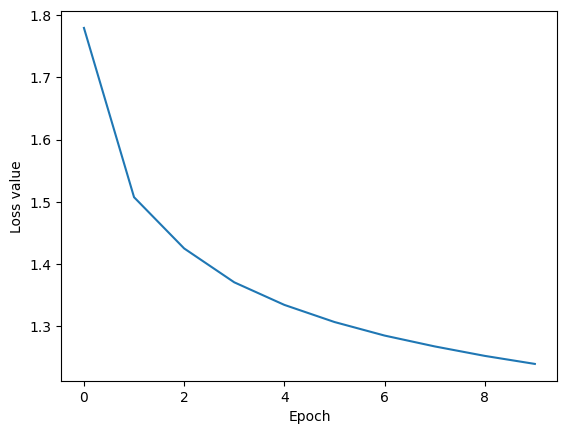

In [20]:
import matplotlib.pyplot as plt

plt.plot(avg_losses_f)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

##Create the function that can sample an index from a probability array
- This function is to prevent the most likely chracter always be chosen.

In [21]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

## Validate the model
- Define the 50 start sentence legth (앞에 seq_lenth 바꾸면 sentence length 바꾸기 가능)
- Predict next char
- Total create 400 characters lyrics

In [26]:
# Define the start sentence
sentence = 'i read in the book\nthat the joyful man\nplease kno'
variance = 0.1
generated = ''
original = sentence
window = sentence

for i in range(700):
    x = np.zeros((1, seq_length))
    for t, char in enumerate(window):
        x[0, t] = char2index[char] # Change the sentence to index vector shape (1,50)

    x_in = Variable(torch.LongTensor(x).cuda())
    pred = model(x_in)
    pred = np.array(F.softmax(pred, dim=1).data[0].cpu())
    next_index = sample(pred, variance)
    next_char = index2char[next_index] # index to char

    generated += next_char
    window = window[1:] + next_char # Update Window for next char predict

print(original + generated)

i read in the book
that the joyful man
please kno o a at
sem u                                   m            m              m         m             m                 m               m                                     m      m                      m                                   m                                             m      m                                             m                 m                                                              m                                                                    m                                   m                   m         m                              m                                                            m                            m                m        


추가과제 -2
## Pytorch로 RNN 구현해보기

## 1. RNN 구현
Pytorch로 neural network 모델을 구현할 때에는 `nn.Module`을 상속받아서 구현하게 됩니다.

### [참고] 객체지향 개념을 잘 모른다면?
객체지향 개념을 잘 모르신다면 <b>상속</b>이란 상속을 받은 클래스 (여기서는 CustomRNN)가 부모 클래스 (`nn.Module`)의 멤버 변수와 메소드를 그대로 넘겨받아 필요에 맞게 재정의하거나 기타 필요한 기능들을 추가해서 사용하는 행위로 쉽게 이해하시면 됩니다. 이를 통해 코드의 중복도를 낮추고 보다 효율적인 설계를 할 수 있습니다.

예를 들어서 `nn.Module` 클래스를 상속받아 만든 모든 클래스들은 `__init()__` 생성자와 `forward()` 메소드를 구현함으로써 모든 neural network가 high level에서는 동일한 동작을 함을 보장할 수 있습니다.

만약 상속 기능을 사용하지 않는다면 모델을 training하는 코드, inference를 하는 코드 등을 neural network 종류마다 새로 짜야 하므로 복잡해집니다.

### 구현 관련 배경지식
`nn.Module` 클래스를 상속받으면 `__init__()` 생성자와 `forward()` 메소드를 구현해야 합니다. 생성자에서는 모델에서 사용할 기본적인 멤버 변수들을 초기화하게 됩니다. 여기서 멤버 변수로는 크게 두 가지가 있습니다.
1. 모델 아키텍쳐와 관련된 dimension들 (각각의 의미는 발제 PPT 참고)
 - Input vector의 길이
 - Hidden layer의 길이
 - Output vector의 길이
 - Batch size


2. 모델에서 사용될 layer들
 - Pytorch의 `nn` module에서는 neural network에서 사용되는 다양한 layer를 미리 구현해 두었습니다. Convolution layer, pooling layer, linear layer 등이 정의되어 있어서 복잡한 연산을 직접 구현할 필요가 없습니다. 본 과제에서는 해당 layer를 쌓아서 RNN을 구현한다고 보시면 됩니다.
 - 본 과제에서는 Linear layer만 활용하면 됩니다. 이는 MLP 세션에서 배운 fully connected layer와 같습니다. FC layer이므로 input, output의 size와 bias 사용 유무만 정의해주면 됩니다. https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear


생성자를 정의했으면 `forward()` 함수를 정의할 차례입니다. `forward()` 메소드가 모델 구현에서 핵심입니다. 이 메소드는 모델에 input data를 집어넣으면 자동으로 호출되고 argument로 input이 전달됩니다. 앞서 정의한 layer들을 잘 호출해서 메소드를 구현하시면 됩니다.


*Backward pass는 모델 train을 할 때 `backward()`가 알아서 해주기 때문에 `forward()`만 정의하는 것입니다.

In [27]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [28]:
# nn.Module을 상속받아서 CustomRNN class 정의

class CustomRNN(nn.Module):
    """
    RNN basic block
    """
    def __init__(self, input_size, hidden_size, output_size):
        """
        input_size: Input vector 길이
        hidden_size: Hidden state vector 길이
        output_size: Output vector 길이
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.W_xh = nn.Linear(input_size, hidden_size, bias=False)
        ##################################################################
        # TODO: 필요한 멤버 변수 2개를 추가로 정의하세요.
        #
        # 1. W_hh: hidden layer vector에 곱해지는 weight
        # 2. W_hy: hidden layer로 output을 생성할 때 곱해지는 weight
        #
        # Hint: 위의 self.W_xh 코드를 참고하세요.
        #
        ##################################################################
        # 아래 주석 해제 후 정의하시면 됩니다. bias는 둘 다 True로 해주세요.
        self.W_hh = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_hy = nn.Linear(hidden_size, output_size, bias=True)
        ##################################################################
        #                         END OF YOUR CODE                       #
        ##################################################################

    def forward(self, x, hidden_state):
        W_xh_x = self.W_xh(x)  # W_xh weight에 input x를 곱해준 결과
        ##################################################################
        # TODO: Forward pass를 계산하는 코드를 추가하세요.
        #
        ########################### 전체 과정 ##############################
        #
        # 1. W_xh와 input을 곱한다.
        # 2. W_hh와 {t - 1} 시점에서의 hidden state vector를 곱한다.
        # 3. 둘이 더한다.
        # 4. tanh를 통과시켜서 새로운 hidden state를 만들어낸다.
        # 5. W_hy와 새로운 hidden state를 곱해서 output을 만들어낸다.
        # 6. output과 새로운 hidden state를 return한다.
        #
        # Hint: torch.tanh
        #
        ##################################################################
        # 아래 주석 해제 후 추가하시면 됩니다.
        W_hh_x = self.W_hh(hidden_state)
        hidden_state = torch.tanh(W_hh_x + W_xh_x)
        output = self.W_hy(hidden_state)
        ##################################################################
        #                         END OF YOUR CODE                       #
        ##################################################################
        # 아래 주석도 해제하세요.
        return output, hidden_state

In [29]:
model = CustomRNN(5, 6, 7)
model_str = str(model).splitlines()
import numpy
stack = []
for i in range(1, 4):
    stack.append(int(model_str[i][29]))
    stack.append(int(model_str[i][45]))

prod = numpy.prod(stack)

if prod == 45360:
    print("Correct!!!")
else:
    print("Incorrect...")

Correct!!!
